### Библиотеки

In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback

### Подготовка данных

In [3]:
data_dir = './images/'
file_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.jpg')]
labels = [fname.split('_')[0] for fname in os.listdir(data_dir) if fname.endswith('.jpg')]

label_to_id = {label: idx for idx, label in enumerate(set(labels))}
ids = [label_to_id[label] for label in labels]

X_train, X_test, y_train, y_test = train_test_split(file_paths, ids, test_size=0.2, random_state=42)

id_to_label = {idx: label for label, idx in label_to_id.items()}
train_labels = [id_to_label[id] for id in y_train]
test_labels = [id_to_label[id] for id in y_test]

train_df = pd.DataFrame({'filename': X_train, 'class': train_labels})
test_df = pd.DataFrame({'filename': X_test, 'class': test_labels})

###  Генерация данных для обучения и тестирования

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df, x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='categorical'
)

Found 5912 validated image filenames belonging to 35 classes.
Found 1478 validated image filenames belonging to 35 classes.


In [5]:
from collections import Counter

unique_labels = set(labels)
print("Уникальные породы:", unique_labels)
print("Количество уникальных пород:", len(unique_labels))

label_counts = Counter(labels)
print("Количество образцов по породам:", label_counts)

train_label_counts = Counter(train_labels)
print("Количество образцов по породам в тренировочных данных:", train_label_counts)

test_label_counts = Counter(test_labels)
print("Количество образцов по породам в тестовых данных:", test_label_counts)

Уникальные породы: {'newfoundland', 'British', 'pomeranian', 'boxer', 'keeshond', 'miniature', 'english', 'staffordshire', 'Russian', 'chihuahua', 'Ragdoll', 'beagle', 'Birman', 'yorkshire', 'Siamese', 'wheaten', 'leonberger', 'great', 'Abyssinian', 'pug', 'Egyptian', 'american', 'Sphynx', 'german', 'samoyed', 'japanese', 'havanese', 'saint', 'scottish', 'basset', 'Bombay', 'shiba', 'Bengal', 'Maine', 'Persian'}
Количество уникальных пород: 35
Количество образцов по породам: Counter({'english': 400, 'american': 400, 'Egyptian': 200, 'pug': 200, 'basset': 200, 'Siamese': 200, 'shiba': 200, 'Birman': 200, 'leonberger': 200, 'saint': 200, 'Abyssinian': 200, 'miniature': 200, 'wheaten': 200, 'pomeranian': 200, 'german': 200, 'newfoundland': 200, 'Sphynx': 200, 'British': 200, 'Bombay': 200, 'boxer': 200, 'great': 200, 'samoyed': 200, 'Russian': 200, 'Persian': 200, 'japanese': 200, 'Ragdoll': 200, 'Maine': 200, 'havanese': 200, 'Bengal': 200, 'keeshond': 200, 'chihuahua': 200, 'beagle': 20

### Определение моделей

In [6]:
def build_model(base_model, num_classes=35):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

base_model_vgg16 = VGG16(weights='./Keras/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
model_vgg16 = build_model(base_model_vgg16)

base_model_vgg19 = VGG19(weights='./Keras/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
model_vgg19 = build_model(base_model_vgg19)

base_model_resnet50 = ResNet50(weights='./Keras/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
model_resnet50 = build_model(base_model_resnet50)

### Обучение

In [7]:
print_loss_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch + 1}: Loss = {logs['loss']}, Val Loss = {logs['val_loss']}"))

history_vgg16 = model_vgg16.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[print_loss_callback])

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0443 - loss: 3.6106Epoch 1: Loss = 3.5525588989257812, Val Loss = 3.3831214904785156
185/185 ━━━━━━━━━━━━━━━━━━━━ 985s 5s/step - accuracy: 0.0444 - loss: 3.6103 - val_accuracy: 0.1069 - val_loss: 3.3831
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.0951 - loss: 3.3828 Epoch 2: Loss = 3.343515396118164, Val Loss = 3.2066407203674316
185/185 ━━━━━━━━━━━━━━━━━━━━ 3776s 20s/step - accuracy: 0.0951 - loss: 3.3826 - val_accuracy: 0.1448 - val_loss: 3.2066
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 69s/step - accuracy: 0.1454 - loss: 3.1919  Epoch 3: Loss = 3.151540994644165, Val Loss = 3.039707660675049
185/185 ━━━━━━━━━━━━━━━━━━━━ 17977s 98s/step - accuracy: 0.1454 - loss: 3.1916 - val_accuracy: 0.1786 - val_loss: 3.0397
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.1782 - loss: 3.0307 Epoch 4: Loss = 2.986992597579956, Val Loss = 2.8763680458068848
185/185 ━━━━━━━━━━━━━━━━━━━━ 6875s 37s/step - acc

In [8]:
history_vgg19 = model_vgg19.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[print_loss_callback])

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0427 - loss: 3.6277Epoch 1: Loss = 3.572208881378174, Val Loss = 3.402837038040161
185/185 ━━━━━━━━━━━━━━━━━━━━ 1306s 7s/step - accuracy: 0.0428 - loss: 3.6274 - val_accuracy: 0.0873 - val_loss: 3.4028
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0827 - loss: 3.4351Epoch 2: Loss = 3.3991196155548096, Val Loss = 3.262754440307617
185/185 ━━━━━━━━━━━━━━━━━━━━ 1334s 7s/step - accuracy: 0.0828 - loss: 3.4350 - val_accuracy: 0.1204 - val_loss: 3.2628
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1238 - loss: 3.2738Epoch 3: Loss = 3.233859062194824, Val Loss = 3.1253445148468018
185/185 ━━━━━━━━━━━━━━━━━━━━ 1581s 9s/step - accuracy: 0.1239 - loss: 3.2736 - val_accuracy: 0.1502 - val_loss: 3.1253
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1703 - loss: 3.1229Epoch 4: Loss = 3.093075752258301, Val Loss = 2.9871151447296143
185/185 ━━━━━━━━━━━━━━━━━━━━ 1596s 9s/step - acc

In [9]:
history_resnet50 = model_resnet50.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[print_loss_callback])

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0359 - loss: 3.7873Epoch 1: Loss = 3.6975293159484863, Val Loss = 3.52636981010437
185/185 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.0359 - loss: 3.7868 - val_accuracy: 0.0622 - val_loss: 3.5264
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0485 - loss: 3.5735Epoch 2: Loss = 3.553809642791748, Val Loss = 3.4942100048065186
185/185 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.0485 - loss: 3.5733 - val_accuracy: 0.0582 - val_loss: 3.4942
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0598 - loss: 3.5135Epoch 3: Loss = 3.507969379425049, Val Loss = 3.474156141281128
185/185 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.0598 - loss: 3.5135 - val_accuracy: 0.0595 - val_loss: 3.4742
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0671 - loss: 3.4877Epoch 4: Loss = 3.4869742393493652, Val Loss = 3.4637181758880615
185/185 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accurac

### Оценка моделей

In [10]:
accuracy_vgg16 = model_vgg16.evaluate(test_generator)
accuracy_vgg19 = model_vgg19.evaluate(test_generator)
accuracy_resnet50 = model_resnet50.evaluate(test_generator)

print("Точность VGG16:", accuracy_vgg16[1])
print("Точность VGG19:", accuracy_vgg19[1])
print("Точность ResNet50:", accuracy_resnet50[1])

47/47 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.4097 - loss: 2.2422
47/47 ━━━━━━━━━━━━━━━━━━━━ 263s 6s/step - accuracy: 0.3818 - loss: 2.3989
47/47 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.0942 - loss: 3.3739
Точность VGG16: 0.41948577761650085
Точность VGG19: 0.37889039516448975
Точность ResNet50: 0.08254397660493851


### Двоичная классификация "кошки против собак"

Самой точной оказалась VGG16. С ней и будем работать

In [11]:
breed_to_type = {
    'Abyssinian': 'cat', 'Bengal': 'cat', 'Birman': 'cat', 'Bombay': 'cat',
    'British': 'cat', 'Egyptian': 'cat', 'Maine': 'cat', 'Persian': 'cat',
    'Ragdoll': 'cat', 'Russian': 'cat', 'Siamese': 'cat', 'Sphynx': 'cat',
    'american': 'dog', 'basset': 'dog', 'beagle': 'dog', 'boxer': 'dog',
    'chihuahua': 'dog', 'english': 'dog', 'german': 'dog', 'great': 'dog',
    'havanese': 'dog', 'japanese': 'dog', 'keeshond': 'dog', 'leonberger': 'dog',
    'miniature': 'dog', 'newfoundland': 'dog', 'pomeranian': 'dog', 'pug': 'dog',
    'saint': 'dog', 'samoyed': 'dog', 'scottish': 'dog', 'shiba': 'dog',
    'staffordshire': 'dog', 'wheaten': 'dog', 'yorkshire': 'dog'
}

binary_labels = [breed_to_type[label.split('_')[0]] for label in labels]

# Стратифицированное разбиение, чтобы гарантировать, что оба класса представлены в обоих наборах данных
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    file_paths, binary_labels,
    test_size=0.2, random_state=42, stratify=binary_labels
)

# Создание DataFrame для тренировочных и тестовых наборов
train_df_binary = pd.DataFrame({'filename': X_train, 'class': y_train_binary})
test_df_binary = pd.DataFrame({'filename': X_test, 'class': y_test_binary})

# Настройка генераторов изображений
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_binary = train_datagen.flow_from_dataframe(
    dataframe=train_df_binary, x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='binary'
)

test_generator_binary = test_datagen.flow_from_dataframe(
    dataframe=test_df_binary, x_col='filename', y_col='class',
    target_size=(224, 224), batch_size=32, class_mode='binary'
)


Found 5912 validated image filenames belonging to 2 classes.
Found 1478 validated image filenames belonging to 2 classes.


In [12]:
print("Количество 'cat' в тренировочных данных:", y_train_binary.count('cat'))
print("Количество 'dog' в тренировочных данных:", y_train_binary.count('dog'))
print("Количество 'cat' в тестовых данных:", y_test_binary.count('cat'))
print("Количество 'dog' в тестовых данных:", y_test_binary.count('dog'))

Количество 'cat' в тренировочных данных: 1920
Количество 'dog' в тренировочных данных: 3992
Количество 'cat' в тестовых данных: 480
Количество 'dog' в тестовых данных: 998


In [13]:
# Строим бинарную модель
def build_binary_model(base_model):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

binary_model_vgg16 = build_binary_model(base_model_vgg16)

In [14]:
history_binary_vgg16 = binary_model_vgg16.fit(train_generator_binary, epochs=10, validation_data=test_generator_binary, callbacks=[print_loss_callback])

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6626 - loss: 0.6038Epoch 1: Loss = 0.5469520688056946, Val Loss = 0.44533392786979675
185/185 ━━━━━━━━━━━━━━━━━━━━ 1195s 6s/step - accuracy: 0.6629 - loss: 0.6034 - val_accuracy: 0.8579 - val_loss: 0.4453
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8178 - loss: 0.4284Epoch 2: Loss = 0.4058314561843872, Val Loss = 0.34558188915252686
185/185 ━━━━━━━━━━━━━━━━━━━━ 1268s 7s/step - accuracy: 0.8179 - loss: 0.4283 - val_accuracy: 0.8843 - val_loss: 0.3456
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8552 - loss: 0.3528Epoch 3: Loss = 0.3389747142791748, Val Loss = 0.29501256346702576
185/185 ━━━━━━━━━━━━━━━━━━━━ 1428s 8s/step - accuracy: 0.8553 - loss: 0.3527 - val_accuracy: 0.8945 - val_loss: 0.2950
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8711 - loss: 0.3266Epoch 4: Loss = 0.30239206552505493, Val Loss = 0.26242050528526306
185/185 ━━━━━━━━━━━━━━━━━━━━ 1440s 8s/step - accu

In [15]:
test_labels_binary = [breed_to_type[label] for label in test_df['class']]
binary_test_df = test_df.copy()
binary_test_df['class'] = test_labels_binary

binary_test_generator = test_datagen.flow_from_dataframe(
    dataframe=binary_test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

binary_accuracy = binary_model_vgg16.evaluate(binary_test_generator)
print("Точность бинарной классификации (кошки против собак):", binary_accuracy[1])

Found 1478 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 305s 7s/step - accuracy: 0.9189 - loss: 0.2012
Точность бинарной классификации (кошки против собак): 0.9248985052108765


### Построение Confusion Matrix

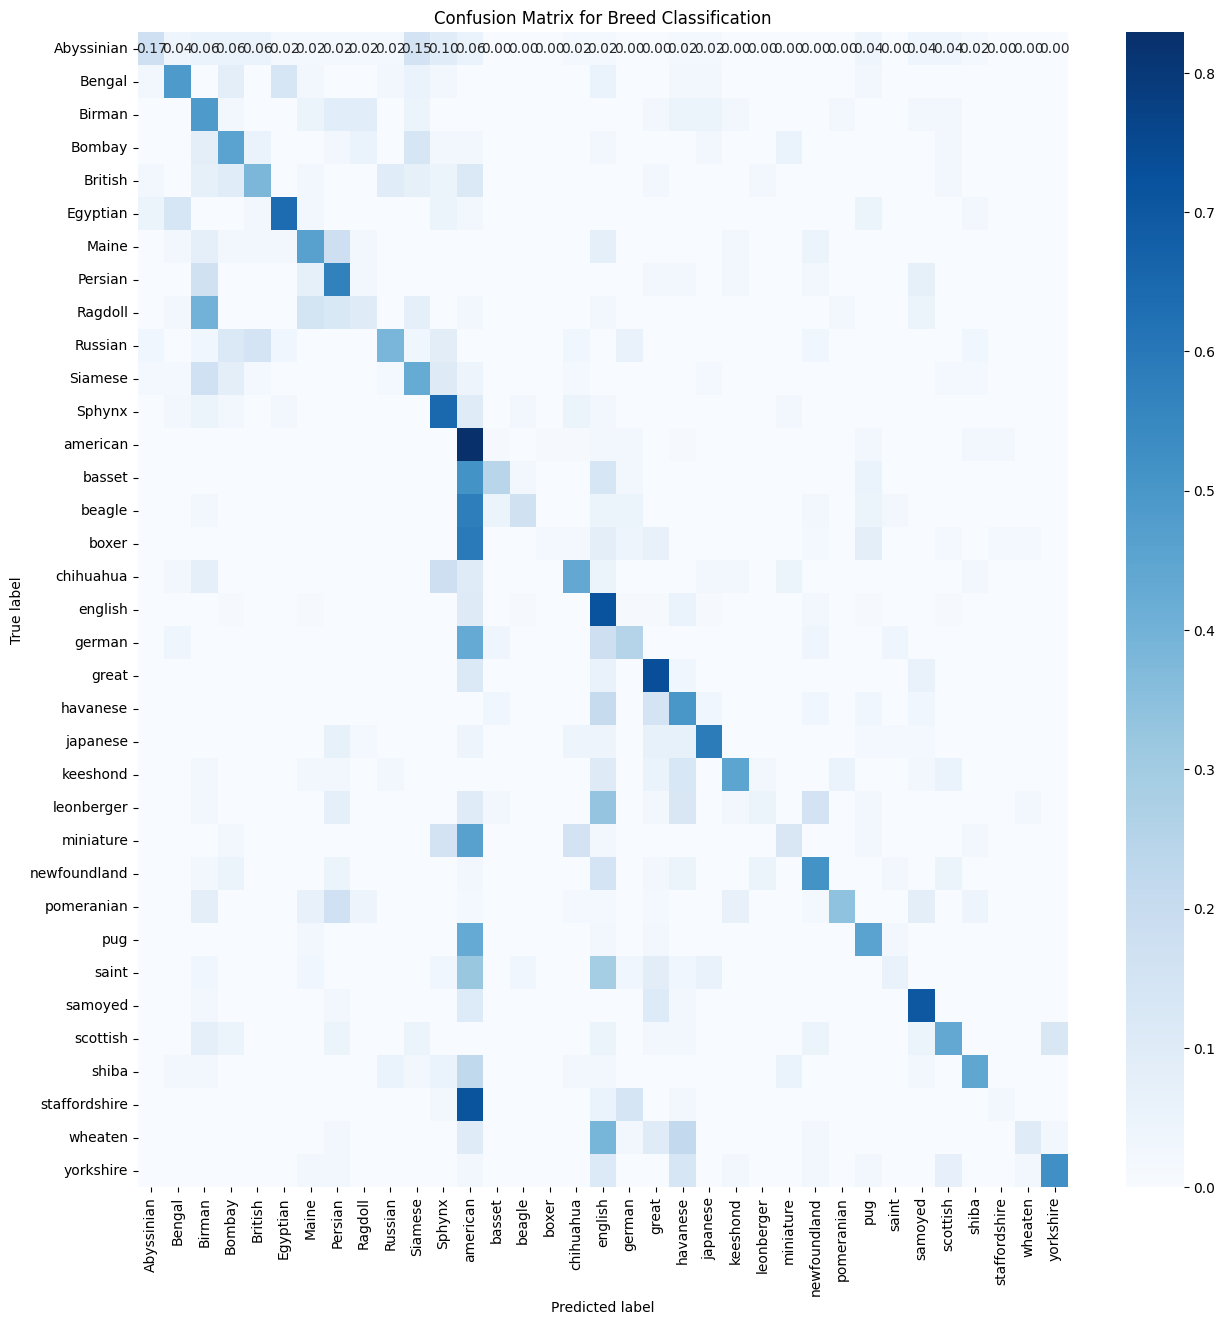

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_predictions(model, generator):
    predictions = []
    labels = []
    generator.reset()
    for _ in range(len(generator)):
        imgs, lbls = next(generator)
        preds = model.predict(imgs, verbose=0)
        preds = np.argmax(preds, axis=1)
        predictions.extend(preds)
        labels.extend(np.argmax(lbls, axis=1))
    return np.array(predictions), np.array(labels)

predictions, true_labels = get_predictions(model_vgg16, test_generator)

class_indices = test_generator.class_indices
breed_names = list(class_indices.keys())

breed_labels = [breed_names[idx] for idx in range(len(class_indices))]

cm = confusion_matrix(true_labels, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15, 15))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=breed_labels, yticklabels=breed_labels)
plt.title('Confusion Matrix for Breed Classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Расчет top-3 и top-5 accuracy

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import top_k_accuracy_score

def get_prob_predictions(model, generator):
    predictions = []
    true_labels = []
    generator.reset()
    for _ in range(len(generator)):
        imgs, lbls = next(generator)
        preds = model.predict(imgs, verbose=0)
        predictions.append(preds)
        true_labels.extend(np.argmax(lbls, axis=1))
    predictions = np.concatenate(predictions, axis=0)
    return predictions, np.array(true_labels)

prob_predictions, true_labels = get_prob_predictions(model_vgg16, test_generator)

top3_accuracy = top_k_accuracy_score(true_labels, prob_predictions, k=3)
top5_accuracy = top_k_accuracy_score(true_labels, prob_predictions, k=5)

print("Top-3 Accuracy:", top3_accuracy)
print("Top-5 Accuracy:", top5_accuracy)

Top-3 Accuracy: 0.7009472259810555
Top-5 Accuracy: 0.8044654939106901


### GradCam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


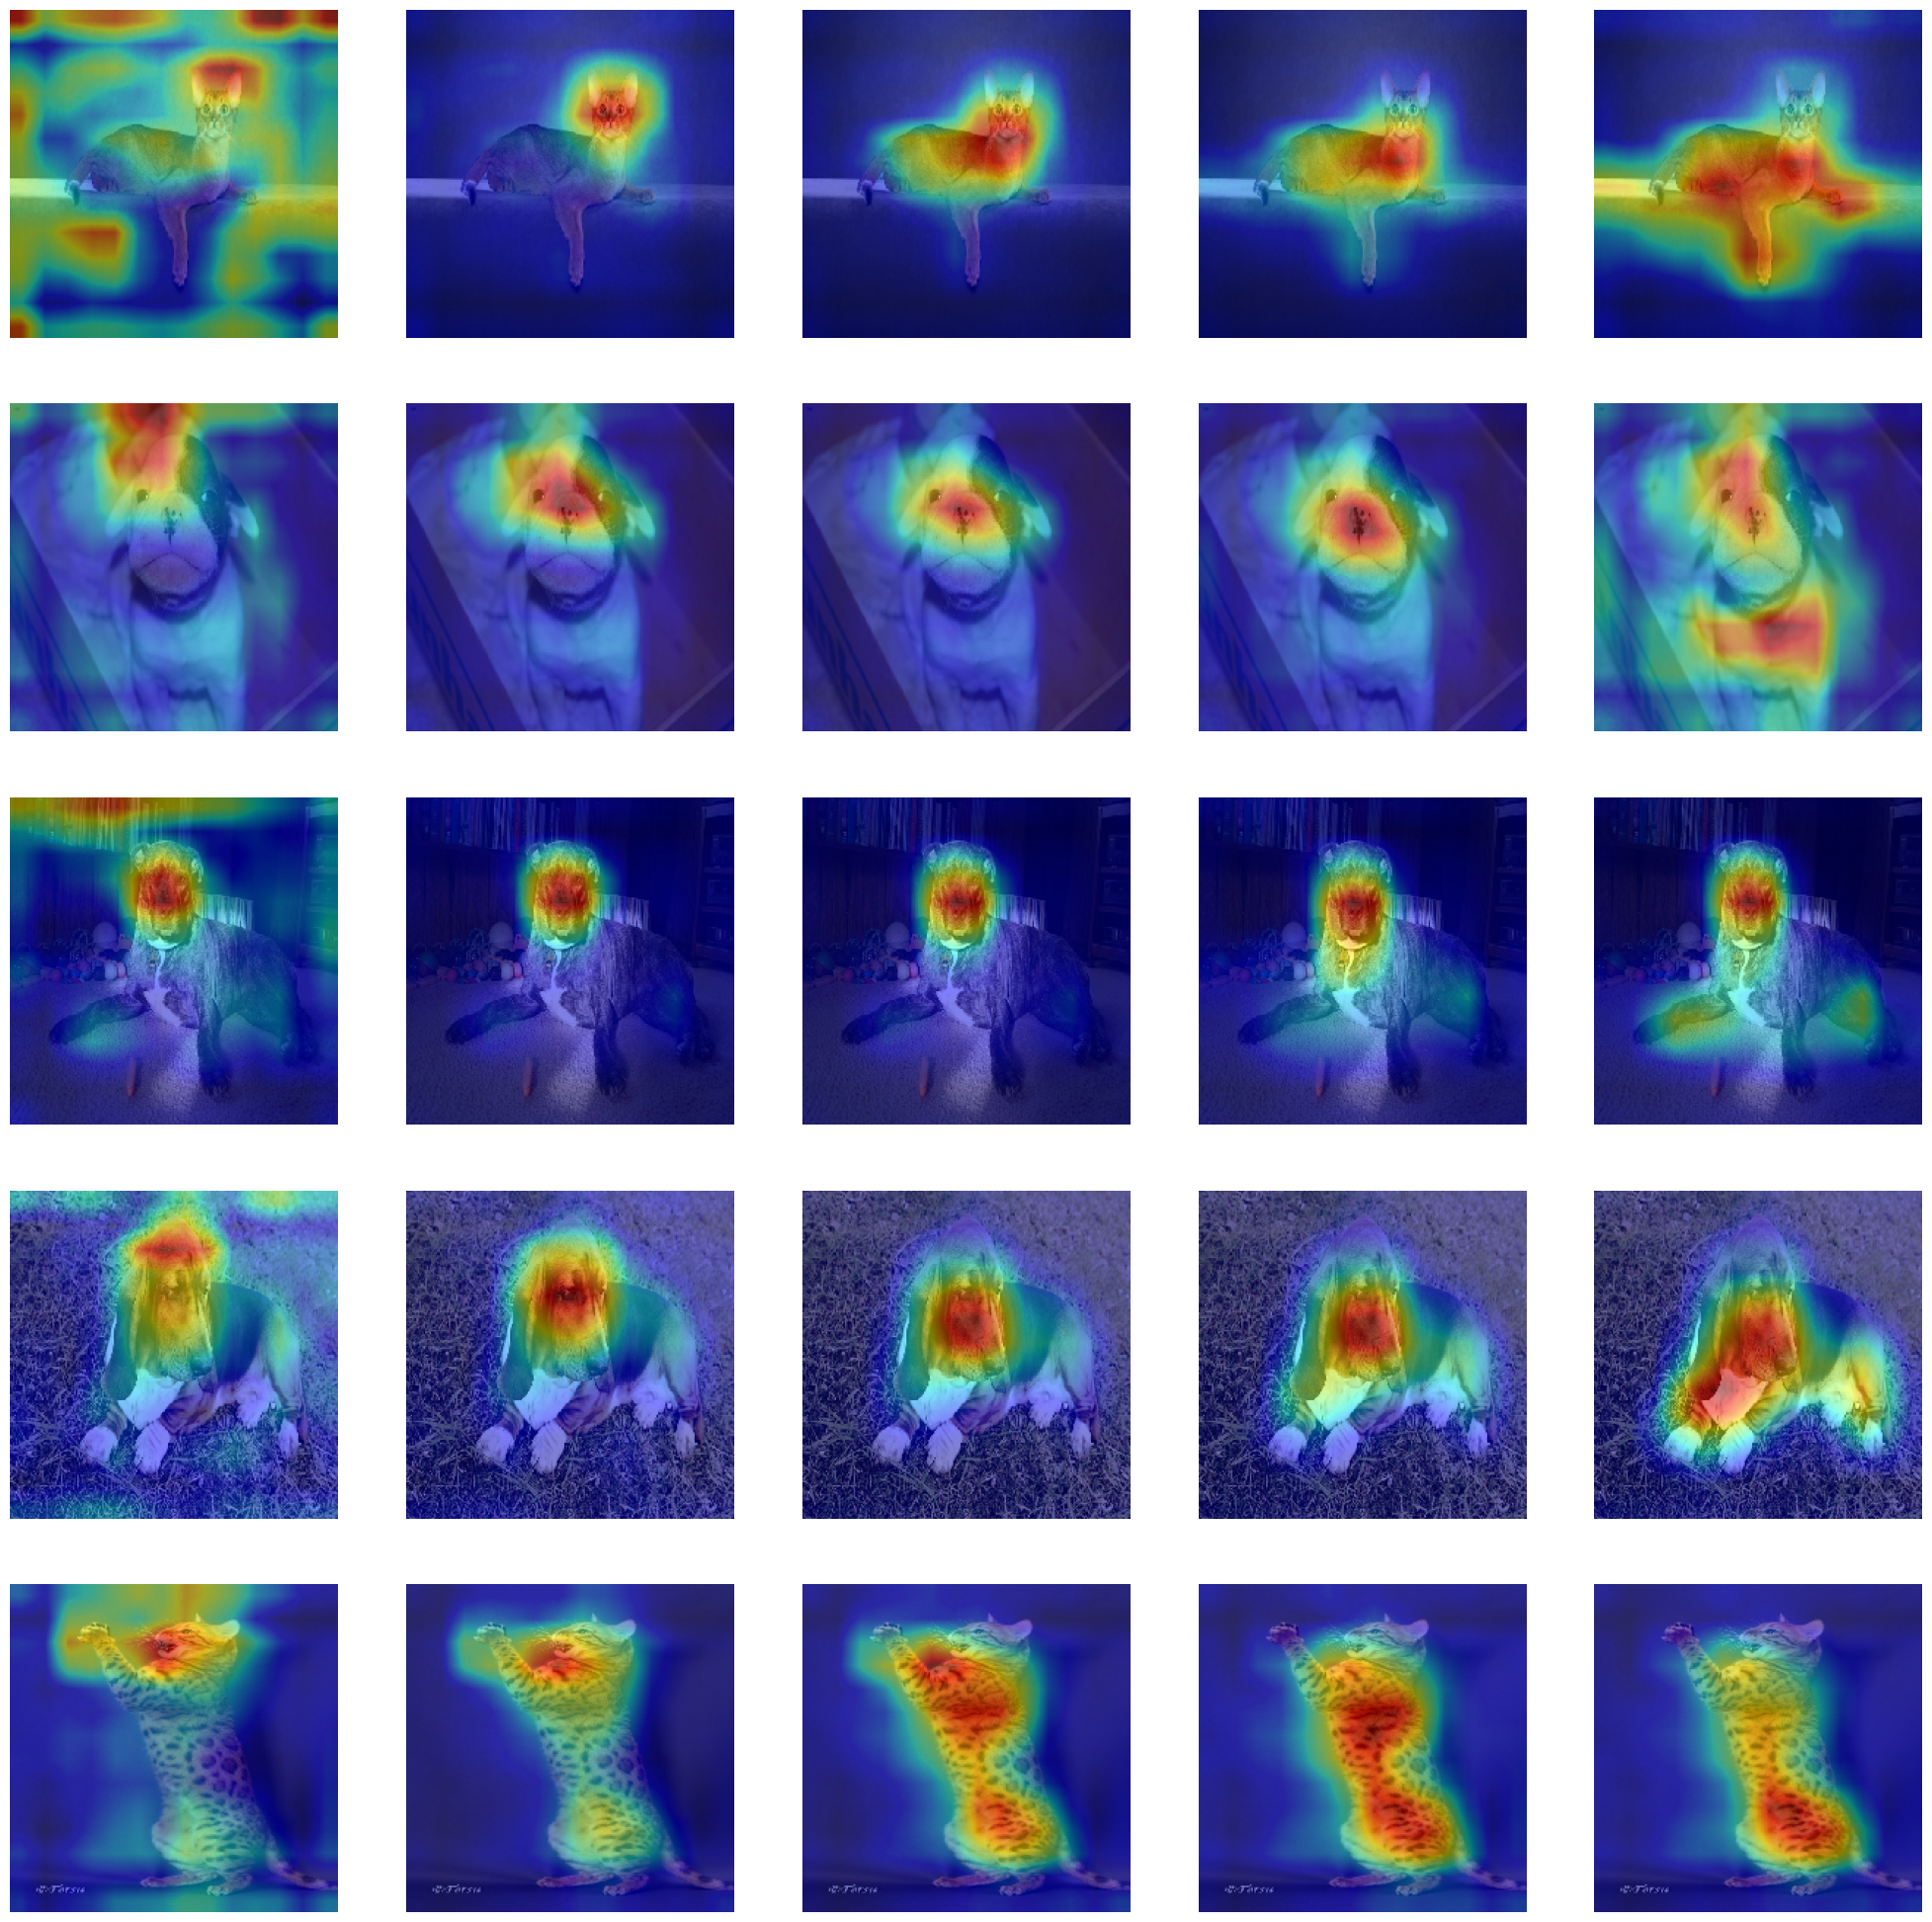

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.models import Model
import tensorflow as tf

def grad_cam(model, image, category_index, layer_name):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, category_index]
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    heatmap = cv2.resize(heatmap, (224, 224))
    return heatmap

def process_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

image_paths = ['./images/Abyssinian_1.jpg', 
               './images/american_bulldog_2.jpg', 
               './images/american_pit_bull_terrier_1.jpg', 
               './images/basset_hound_1.jpg', 
               './images/Bengal_1.jpg'
               ]
layer_name = 'block5_conv3'
model_vgg16 = VGG16(include_top=False, weights=None, input_shape=(224, 224, 3))
model_vgg16.load_weights('./Keras/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

fig, axs = plt.subplots(5, 5, figsize=(25, 25))

for i, img_path in enumerate(image_paths):
    img = process_image(img_path)
    preds = model_vgg16.predict(img)
    predicted_class = np.argmax(preds[0])

    for j in range(5):  # Генерация CAM для первых 5 классов
        cam = grad_cam(model_vgg16, img, j, layer_name)
        axs[i, j].imshow(load_img(img_path, target_size=(224, 224)))
        axs[i, j].imshow(cam, cmap='jet', alpha=0.5)  # Наложение CAM на изображение
        axs[i, j].axis('off')

plt.show()